In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot


In [3]:
# Data Generation
true_b = 1
true_w = 2
N = 100

np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

In [4]:
# Train and validation split

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]
 
# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


In [5]:
# Step 0: Initialize parameters randomly
np.random.seed(42)
w = np.random.randn(1)
b = np.random.randn(1)

print(b, w)

# Set learning rate
lr = 0.1

# Define epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1: Compute predictions
    y_pred = w * x_train + b

    # Step 2: Compute loss
    error = (y_pred - y_train)
    loss = (error ** 2).mean()

    # Step 3: Compute gradients
    grad_b = 2 * error.mean()
    grad_w = 2 * (error * x_train).mean()

    # Step 4: Update parameters
    b = b - lr * grad_b
    w = w - lr * grad_w

print(b,w)
    # Step 5: Print progress
    

[-0.1382643] [0.49671415]
[1.02354084] [1.9689643]


In [6]:
linr = LinearRegression()
linr.fit(x_train, y_train)

print(linr.intercept_, linr.coef_[0])


[1.02354075] [1.96896447]


In [7]:
device = (
    "mps" if torch.backends.mps.is_available() 
    else "cuda" if torch.cuda.is_available() 
    else "cpu"
)
print("Using device:", device)

Using device: mps


In [8]:
import subprocess

gpu_info = subprocess.run(
    ["system_profiler", "SPDisplaysDataType"],
    capture_output=True,
    text=True
).stdout

for line in gpu_info.splitlines():
    if "Chipset Model" in line or "Chip" in line:
        print(line.strip())

Chipset Model: Apple M3 Pro


In [9]:
x_train_float = x_train.astype(np.float32)
gpu_tensor = torch.as_tensor(x_train_float).to(device)

gpu_tensor[0]

tensor([0.7713], device='mps:0')

In [10]:
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(b, w)


tensor([0.9047], device='mps:0', requires_grad=True) tensor([-1.5057], device='mps:0', requires_grad=True)


In [11]:
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)


In [12]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor

    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    # make_dot(yhat)

    # Step 3 - Computes gradients for both "b" and "w"
    # parameters. No more manual computation of gradients!
    # b_grad = 2 * error.mean()
    # w_grad = 2 * (x_tensor * error).mean()
    # We just tell PyTorch to work its way BACKWARDS
    # from the specified
    loss.backward()


    # Step 4 - Updates parameters using gradients and
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # b = b - lr * b.grad                          ①
    # w = w - lr * w.grad                          ①
    # print(b)                                     ①
 
    # SECOND ATTEMPT - using in-place Python assignment
    # RuntimeError: a leaf Variable that requires grad
    # has been used in an in-place operation.
    # b -= lr * b.grad                             ②
    # w -= lr * w.grad                             ②
 
    # THIRD ATTEMPT - NO_GRAD for the win!
    # We need to use NO_GRAD to keep the update out of
    # the gradient computation. Why is that? It boils
    # down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():                          
        b -= lr * b.grad                           
        w -= lr * w.grad                           
 
    # PyTorch is "clingy" to its computed gradients; we
    # need to tell it to let it go...
    b.grad.zero_()                                 
    w.grad.zero_()                                 
 
print(b, w)


tensor([1.0235], device='mps:0', requires_grad=True) tensor([1.9690], device='mps:0', requires_grad=True)


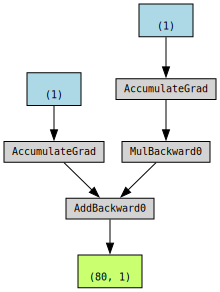

In [13]:
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
# Step 1 - Computes our model's predicted output - forward pass

yhat = b + w * x_train_tensor
# Step 2 - Computes the loss
error = (yhat - y_train_tensor)
loss = (error ** 2).mean()
# We can try plotting the graph for any variable: yhat, error, loss
make_dot(yhat)



In [14]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Defines number of epochs
n_epochs = 1000

optimizer = optim.SGD([b, w], lr=lr)

loss_fn = nn.MSELoss(reduction='mean')

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)
    # make_dot(yhat)

    # Step 3 - Computes gradients for both "b" and "w"
    # parameters. No more manual computation of gradients!
    # b_grad = 2 * error.mean()
    # w_grad = 2 * (x_tensor * error).mean()
    # We just tell PyTorch to work its way BACKWARDS
    # from the specified
    loss.backward()


    # Step 4 - Updates parameters using gradients and
    # the learning rate. But not so fast...
    optimizer.step()                          
 
    # PyTorch is "clingy" to its computed gradients; we
    # need to tell it to let it go...
    optimizer.zero_grad()                                 
 
print(b, w)


tensor([1.0235], device='mps:0', requires_grad=True) tensor([1.9690], device='mps:0', requires_grad=True)


In [15]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "b" and "w" real parameters of the model,
        # we need to wrap them with nn.Parameter
        self.b = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))
 
    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.w * x

torch.manual_seed(42)

dummy = ManualLinearRegression()
list(dummy.parameters())

dummy.state_dict()



OrderedDict([('b', tensor([0.3367])), ('w', tensor([0.1288]))])

In [16]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

In [17]:
# Sets learning rate - this is "eta" ~ the "n"-like
# Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)       
 
# Defines an SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)
 
# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    model.train() # What is this?!?                
 
    # Step 1 - Computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)                   
 
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)
 
    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
 
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
 
# We can also inspect its parameters using its state_dict
print(model.state_dict())


OrderedDict([('b', tensor([1.0235], device='mps:0')), ('w', tensor([1.9690], device='mps:0'))])


In [23]:
model = nn.Sequential(nn.Linear(3, 5)).to(device)

model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3013,  0.3034,  0.2159],
                      [-0.1015, -0.1529,  0.0618],
                      [-0.1020, -0.1721,  0.3690],
                      [ 0.4962, -0.0572, -0.1293],
                      [ 0.0084, -0.0345,  0.1388]], device='mps:0')),
             ('0.bias',
              tensor([ 0.1618, -0.5244, -0.2131,  0.4862,  0.2249], device='mps:0'))])

In [ ]:
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)

model.state_dict()


OrderedDict([('0.weight',
              tensor([[-0.0287, -0.3481, -0.3532],
                      [-0.5172, -0.1882,  0.1950],
                      [ 0.3681,  0.2666, -0.5103],
                      [-0.3472, -0.0911,  0.5585],
                      [ 0.0835, -0.1495,  0.2389]], device='mps:0')),
             ('0.bias',
              tensor([-0.2199, -0.3737,  0.4214, -0.2625, -0.1157], device='mps:0')),
             ('1.weight',
              tensor([[-0.4449,  0.2993,  0.3388,  0.1630, -0.3118]], device='mps:0')),
             ('1.bias', tensor([-0.4414], device='mps:0'))])

In [26]:
%%writefile data_preparation/v0.py
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then send them to the
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)


Writing data_preparation/v0.py


In [27]:
%run -i data_preparation/v0.py


In [29]:
%%writefile model_configuration/v0.py
 
# This is redundant now, but it won't be when we introduce
# Datasets...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
 
torch.manual_seed(42)
 
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)
 
# Defines an SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)
 
# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')


Writing model_configuration/v0.py


In [30]:
%%writefile model_training/v0.py
 
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()
 
    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor)
 
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)
 
    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()



Writing model_training/v0.py
